In [41]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [42]:
spark = SparkSession.builder.appName("Credit Card Fraud Detection").getOrCreate()

In [43]:
csv_file = "credit_card_info.csv"
df = spark.read.csv(csv_file, header=True, inferSchema=True)

In [44]:
indexers = ["repeat_retailer", "used_chip", "used_pin_number", "online_order"]
for column in indexers:
    indexer = StringIndexer(inputCol=column, outputCol=column + "_index")
    df = indexer.fit(df).transform(df)

In [45]:
feature_columns = [
    "distance_from_home", "distance_from_last_transaction",
    "ratio_to_median_purchase_price", "repeat_retailer_index",
    "used_chip_index", "used_pin_number_index", "online_order_index"
]

In [46]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

In [47]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [48]:
rf = RandomForestClassifier(labelCol="fraud", featuresCol="features", numTrees=100, maxDepth=5)
rf_model = rf.fit(train_data)

25/02/17 01:21:33 WARN MemoryStore: Not enough space to cache rdd_70_4 in memory! (computed 18.4 MiB so far)
25/02/17 01:21:33 WARN BlockManager: Persisting block rdd_70_4 to disk instead.
25/02/17 01:21:33 WARN MemoryStore: Not enough space to cache rdd_70_0 in memory! (computed 18.4 MiB so far)
25/02/17 01:21:33 WARN BlockManager: Persisting block rdd_70_0 to disk instead.
25/02/17 01:21:33 WARN MemoryStore: Not enough space to cache rdd_70_1 in memory! (computed 18.4 MiB so far)
25/02/17 01:21:33 WARN BlockManager: Persisting block rdd_70_1 to disk instead.
25/02/17 01:21:33 WARN MemoryStore: Not enough space to cache rdd_70_2 in memory! (computed 28.0 MiB so far)
25/02/17 01:21:33 WARN BlockManager: Persisting block rdd_70_2 to disk instead.
25/02/17 01:21:34 WARN MemoryStore: Not enough space to cache rdd_70_5 in memory! (computed 41.9 MiB so far)
25/02/17 01:21:34 WARN BlockManager: Persisting block rdd_70_5 to disk instead.
25/02/17 01:21:34 WARN MemoryStore: Not enough space to

In [49]:
predictions = rf_model.transform(test_data)

In [50]:
evaluator = BinaryClassificationEvaluator(labelCol="fraud", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

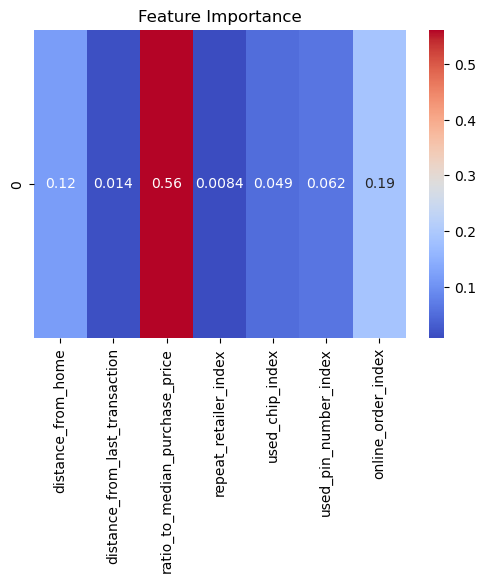

In [51]:
feature_importance = rf_model.featureImportances.toArray()
plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(feature_importance.reshape(1, -1), columns=feature_columns), annot=True, cmap="coolwarm")
plt.title("Feature Importance")
plt.show()

spark.stop()